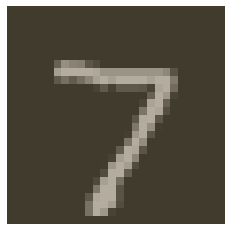

In [10]:
# Section Project:
# For the final project for this section, you're going to train a DP model using this PATE method on the MNIST dataset, provided below.

# *********** Load the data **********
import torch
from torch import nn
import helper
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(mnist_trainset,batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(mnist_testset,batch_size=64)

# *********** Check the data **********
img, label = next(iter(testloader))
helper.imshow(img[0])


In [2]:
# *********** Part from the exercise **********
# TODO how can I use it?
train_data = mnist_trainset.data
train_targets = mnist_trainset.targets

print(train_data.shape)

test_data = mnist_trainset.data
test_targets = mnist_trainset.targets

print(test_data.shape)

torch.Size([60000, 28, 28])
torch.Size([60000, 28, 28])


In [3]:
# *********** Prepare input for PATH analysis **********
num_teachers = 100
num_examples = len(mnist_trainset)
num_labels = 10

lengths  = [len(mnist_trainset)//num_teachers]*num_teachers
trainsets = torch.utils.data.random_split(mnist_trainset, lengths)

print('num_examples:', num_examples)
len(lengths)

num_examples: 60000


100

In [4]:
# *********** Create the model **********
from collections import OrderedDict

model = nn.Sequential(OrderedDict([
    ('fc1',  nn.Linear(784, 512)),
    ('relu', nn.ReLU()),
    ('drop', nn.Dropout(p=0.2)),
    ('fc2',  nn.Linear(512, 128)),
    ('relu', nn.ReLU()),
    ('fc3',  nn.Linear(128, 10)),
    ('output', nn.LogSoftmax(dim=1))
]))

In [9]:
# *********** Train the model **********
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
   
model.to(device)

epochs = 3
step = 0
print_every = 100
# TODO ...
for ii in range(num_teachers):
    print('Trainset:', ii)
    for e in range(epochs):
        running_loss = 0
        trainloader = torch.utils.data.DataLoader(trainsets[ii], batch_size=64, shuffle=True)
        for imgs, labels in trainloader:
            step += 1
            imgs = imgs.view(imgs.shape[0], -1)
            imgs, labels = imgs.to(device), labels.to(device)

            optimizer.zero_grad()

            logps = model(imgs)
            loss = criterion(logps, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        else:
            with torch.no_grad():
                model.eval()
                test_loss = 0
                accuracy  = 0
                
                for imgs, labels in testloader:
                    imgs = imgs.view(imgs.shape[0], -1)
                    imgs, labels = imgs.to(device), labels.to(device)

                    logps = model(imgs)
                    loss = criterion(logps, labels)
                    test_loss += loss.item()

                    ps = torch.exp(logps)
                    top_ps, top_class = ps.topk(1, dim=1)
                    equality = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equality.type(torch.FloatTensor)).item()

            print('Training loss:', running_loss/print_every)
            print('Test loss:', test_loss/len(testloader))
            print('Accuracy:', accuracy/len(testloader))

Trainset: 0
Training loss: 0.012487928010523319
Test loss: 0.2594364644235866
Accuracy: 0.9452627388535032
Training loss: 0.0024955584364943204
Test loss: 0.21162161297479254
Accuracy: 0.9553144904458599
Training loss: 0.000900308690033853
Test loss: 0.21246595704441618
Accuracy: 0.9537221337579618
Trainset: 1
Training loss: 0.0028604119084775447
Test loss: 0.20023929261288065
Accuracy: 0.9564092356687898
Training loss: 0.0003781065344810486
Test loss: 0.20491542092933776
Accuracy: 0.9552149681528662
Training loss: 0.0001850651454878971
Test loss: 0.22354115147119874
Accuracy: 0.9511345541401274
Trainset: 2
Training loss: 0.0021166251105023547
Test loss: 0.21345457012296482
Accuracy: 0.9545183121019108
Training loss: 0.0008040024596266449
Test loss: 0.23464136784243736
Accuracy: 0.9507364649681529
Training loss: 0.00037728483555838466
Test loss: 0.2052653792557443
Accuracy: 0.9552149681528662
Trainset: 3
Training loss: 0.0033617834001779556
Test loss: 0.25942441901773405
Accuracy: 0.94

KeyboardInterrupt: 

In [ ]:
# *********** PATE analysis **********
# TODO

In [ ]:

#data_dep_eps, data_ind_eps = pate.perform_analysis(teacher_preds=preds, indices=indices, noise_eps=0.1, delta=1e-5, moments=20)
#print("Data Independent Epsilon:", data_ind_eps)
#print("Data Dependent Epsilon:", data_dep_eps)